## NLP Class Assignment 5

Author: Aashish Singh

You have been provided with a starter notebook that reads a collection of tweets and a collection of news articles about one particular company. You goals are:

- Identify what is this company name, by looking at the entity distributions across both tweets and news articles
  - While analyzing news articles, extract separate entities from titles and texts
- Identify what other companies are most frequently mentioned along with your primary company
  - What companies are most frequently mentioned within the same document (tweet and news article) as your primary company.
- Identify most frequent locations of events, by extracting appropriate named entities
  - Locations may include countries, states, cities, regions, etc.
 

In order to complete this analysis:

- Discard non-English results
- Apply appropriate text cleaning methods
- Within your Jupyter notebook:
  - Show a table or chart with your top-20 companies (sorted in the descending order)
  - You are welcome to use separate tables for titles and texts of the news articles
- Use a couple of different NER packages and options, (i.e. both NLTK and SpaCy, also with and without sentence segmentation).  This way you can evaluate which model provided you the best results
  - Your top-20 list should only be based on your most accurate results from the best performing NER package

In [1]:
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !pip install pandarallel

In [2]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import re
import nltk
import nltk.corpus  
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.tree import Tree
from nltk import ne_chunk, pos_tag, word_tokenize
import spacy
from spacy.tokens import DocBin
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pandarallel import pandarallel

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()

print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 12
INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Read news data

In [4]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_5_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(5)

Sample contains 10,012 news articles


,url,date,language,title,text
0,http://kokomoperspective.com/obituaries/jon-w-horton/article_b6ba8e1e-cb9c-11eb-9868-fb11b88b9778.html,2021-06-13,en,Jon W. Horton | Obituaries | kokomoperspective.com,Jon W. Horton | Obituaries | kokomoperspective.comYou have permission to edit this article. EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID-19Click here for the latest local news on COVID-19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagements/Anniversaries/WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee-EditionCouponsGalleries74°...
1,https://auto.economictimes.indiatimes.com/news/auto-components/birla-precision-to-ramp-up-capacity-to-tap-emerging-opportunities-in-india/81254902,2021-02-28,en,"Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto","Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto We have updated our terms and conditions and privacy policy Click ""Continue"" to accept and continue with ET AutoAccept the updated privacy & cookie policyDear user, ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy & our cookie ..."
2,https://ca.sports.yahoo.com/news/global-hydrogen-fueling-station-markets-104800330.html?src=rss,2021-12-07,en,Global Hydrogen Fueling Station Markets to 2035: Current State and Future Prognosis of Passenger Hydrogen Fuel Cell Vehicles (FCVs),Global Hydrogen Fueling Station Markets to 2035: Current State and Future Prognosis of Passenger Hydrogen Fuel Cell Vehicles (FCVs) HOME MAIL NEWS SPORTS FINANCE CELEBRITY STYLE MOVIES WEATHER MOBILE Yahoo Sports Sign in Mail Sign in to view your mail Sports Home Sports Home Fantasy Fantasy Fantasy FootballFantasy Football Fantasy HockeyFantasy Hockey Fantasy BasketballFantasy Basketball Fantasy Auto RacingFantasy Auto Racing Fantasy Go...
3,https://cardealermagazine.co.uk/publish/july-20-backlash-over-covid-passports-cummings-leaks-more-pm-texts-extreme-heat-warning-anniversary-mini-cooper-jcw-revealed/228570,2021-07-20,en,July 20: Backlash over Covid passports; Cummings leaks more PM texts; Extreme heat warning; Anniversary Mini Cooper JCW revealed – Car Dealer Magazine,July 20: Backlash over Covid passports; Cummings leaks more PM texts; Extreme heat warning; Anniversary Mini Cooper JCW revealed – Car Dealer Magazine Log inCar Dealer Magazine LogoThe logo for Car Dealer Magazine Log inLatestUsed CarsLiveForumJobsPowerUCA 2020UCA 2021KnowledgeSuppliers GuideLatest IssueTop 100Home > News Round-Up > July 20: Backlash over Covid passports; Cummings leaks more PM texts; Extreme heat warning; Anniversary Mini Cooper JCW revealedNews Round-UpJuly 20: Backlash ov...
4,https://fox5sandiego.com/news/local-news/nonprofit-threatens-lawsuit-over-whales-found-dead-at-naval-base-san-diego/,2021-05-17,en,Nonprofit threatens lawsuit over whales found dead at Naval Base San Diego | FOX 5 San Diego,Nonprofit threatens lawsuit over whales found dead at Naval Base San Diego | FOX 5 San DiegoSkip to contentFOX 5 San DiegoSan Diego65°Sponsored By Toggle MenuOpen NavigationClose NavigationSearchPrimary MenuVideoFOX 5 News LiveLive EventsFOX 5 News NowVideo CenterFOX 5 Program ScheduleNewsNews AppsEmail NewslettersNews tips and story ideasLocalCaliforniaNationalWorldCOVID-19HealthEarthquakesEntertainmentBusinessTechnologyMorning NewsAuto UpdateVideo Game & Pop Culture NewsPoliticsTrafficExp...


#### Read Tweets data

In [5]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_5_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(5)

Sample contains 10,105 tweets


,id,lang,date,name,retweeted,text
0,1534565117614084096,en,2022-06-08,Low Orbit Tourist 🌍📷,,"Body &amp; Assembly - Halewood - United Kingdom\n🌍53.3504,-2.8352296,402m\n\nHalewood Body &amp; Assembly is a Jaguar Land Rover factory in Halewood, England, and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site. [Wikipedia] https://t.co/LPmCnZIaVt"
1,1534565743429394439,en,2022-06-08,CompleteCar.ie,RT,"Land Rover Ireland has announced that the new Range Rover Sport starts at €114,150, now on @completecar:\n\nhttps://t.co/TjGUkL3FYr https://t.co/QdVaEiJkjO"
2,1529341557580652545,en,2022-05-25,Exmoor Trim,,New Land Rover Range Rover Hits Top Speed With Ease On Autobahn\n\nhttps://t.co/19QOgAIu3v
3,1542790343535755264,en,2022-07-01,Land Rover UK,,"@BeckyWatts1 Hi, thank you for your post. I am sorry to learn of your retailer experience, however when order slots are available they will be presented to the retailer, and it is at their discretion which vehicles they submit. Please continue to liaise with them. Thanks, Dan - Land Rover UK"
4,1516732103370493954,en,2022-04-20,Sussexes❤️👑🐼🌸,,@cofvefe917 @Mackingday No this was during the Land Rover driving challenge.


In [6]:
# Combine news titles and text
news_df['combined_text'] = news_df['title'] + '. ' + news_df['text']

In [7]:
# Filter only English results
news_df = news_df[news_df['language'] == 'en']
tweets_df = tweets_df[tweets_df['lang'] == 'en']

In [8]:
nltk.download('punkt')

# Define the text cleaning function
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aashishsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Let's apply cleaning to news text and title
news_df['clean_title'] = news_df['title'].apply(clean_text)
news_df['clean_text'] = news_df['text'].apply(clean_text)
news_df['clean_title_text'] = news_df['clean_title'] + ' ' + news_df['clean_text']
news_df.head(5)

,url,date,language,title,text,combined_text,clean_title,clean_text,clean_title_text
0,http://kokomoperspective.com/obituaries/jon-w-horton/article_b6ba8e1e-cb9c-11eb-9868-fb11b88b9778.html,2021-06-13,en,Jon W. Horton | Obituaries | kokomoperspective.com,Jon W. Horton | Obituaries | kokomoperspective.comYou have permission to edit this article. EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID-19Click here for the latest local news on COVID-19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagements/Anniversaries/WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee-EditionCouponsGalleries74°...,Jon W. Horton | Obituaries | kokomoperspective.com. Jon W. Horton | Obituaries | kokomoperspective.comYou have permission to edit this article. EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID-19Click here for the latest local news on COVID-19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagements/Anniversaries/WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVi...,Jon W Horton Obituaries kokomoperspectivecom,Jon W Horton Obituaries kokomoperspectivecomYou permission edit article EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVIDClick latest local news COVIDHomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagementsAnniversariesWeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotiveeEditionCouponsGalleriesFair Kokomo IN TodayA clouds A stray shower thunderstorm possible Low F Winds light variabl...,Jon W Horton Obituaries kokomoperspectivecom Jon W Horton Obituaries kokomoperspectivecomYou permission edit article EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVIDClick latest local news COVIDHomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagementsAnniversariesWeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotiveeEditionCouponsGalleriesFair Kokomo IN TodayA clouds A stray shower th...
1,https://auto.economictimes.indiatimes.com/news/auto-components/birla-precision-to-ramp-up-capacity-to-tap-emerging-opportunities-in-india/81254902,2021-02-28,en,"Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto","Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto We have updated our terms and conditions and privacy policy Click ""Continue"" to accept and continue with ET AutoAccept the updated privacy & cookie policyDear user, ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy & our cookie ...","Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto. Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto We have updated our terms and conditions and privacy policy Click ""Continue"" to accept and continue with ET AutoAccept the updated privacy & cookie policyDear user, ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and ...",Birla Precision ramp capacity tap emerging opportunities India Auto News ET Auto,Birla Precision ramp capacity tap emerging opportunities India Auto News ET Auto We updated terms conditions privacy policy Click Continue accept continue ET AutoAccept updated privacy cookie policyDear user ET Auto privacy cookie policy updated align new data regulations European Union Please review accept changes continue using websiteYou see privacy policy cookie policy We use cookies ensure best experience websiteIf choose ignore message well assume h

In [10]:
# Let's apply cleaning to tweet text
tweets_df['clean_text'] = tweets_df['text'].apply(clean_text)
tweets_df.head(5)

,id,lang,date,name,retweeted,text,clean_text
0,1534565117614084096,en,2022-06-08,Low Orbit Tourist 🌍📷,,"Body &amp; Assembly - Halewood - United Kingdom\n🌍53.3504,-2.8352296,402m\n\nHalewood Body &amp; Assembly is a Jaguar Land Rover factory in Halewood, England, and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site. [Wikipedia] https://t.co/LPmCnZIaVt",Body amp Assembly Halewood United Kingdom Halewood Body amp Assembly Jaguar Land Rover factory Halewood England forms major part Halewood complex shared Ford manufacture transmissions site Wikipedia httpstcoLPmCnZIaVt
1,1534565743429394439,en,2022-06-08,CompleteCar.ie,RT,"Land Rover Ireland has announced that the new Range Rover Sport starts at €114,150, now on @completecar:\n\nhttps://t.co/TjGUkL3FYr https://t.co/QdVaEiJkjO",Land Rover Ireland announced new Range Rover Sport starts completecar httpstcoTjGUkLFYr httpstcoQdVaEiJkjO
2,1529341557580652545,en,2022-05-25,Exmoor Trim,,New Land Rover Range Rover Hits Top Speed With Ease On Autobahn\n\nhttps://t.co/19QOgAIu3v,New Land Rover Range Rover Hits Top Speed With Ease On Autobahn httpstcoQOgAIuv
3,1542790343535755264,en,2022-07-01,Land Rover UK,,"@BeckyWatts1 Hi, thank you for your post. I am sorry to learn of your retailer experience, however when order slots are available they will be presented to the retailer, and it is at their discretion which vehicles they submit. Please continue to liaise with them. Thanks, Dan - Land Rover UK",BeckyWatts Hi thank post I sorry learn retailer experience however order slots available presented retailer discretion vehicles submit Please continue liaise Thanks Dan Land Rover UK
4,1516732103370493954,en,2022-04-20,Sussexes❤️👑🐼🌸,,@cofvefe917 @Mackingday No this was during the Land Rover driving challenge.,cofvefe Mackingday No Land Rover driving challenge


#### Using Basic NER Approach (with and without sentence segmentation)

In [11]:
# Define function to extract named entities using NLTK (without sentence segmentation)
def get_named_entities_nltk(text):
    entities = []
    labels = []
    for chunk in ne_chunk(pos_tag(word_tokenize(text)), binary=False):
        if hasattr(chunk, 'label') and chunk.label() == 'ORGANIZATION':
            entities.append(' '.join(c[0] for c in chunk))  # Add space between multi-token entities
            labels.append(chunk.label())
    return entities, labels

# Define function to extract named entities using NLTK (with sentence segmentation)
def get_named_entities_nltk_sentences(text):
    entities = []
    labels = []
    for sent in nltk.sent_tokenize(text):
        for chunk in ne_chunk(pos_tag(word_tokenize(sent)), binary=False):
            if hasattr(chunk, 'label') and chunk.label() == 'ORGANIZATION':
                entities.append(' '.join(c[0] for c in chunk))  # Add space between multi-token entities
                labels.append(chunk.label())
    return entities, labels

# Combine all texts from news title, news text, tweets text
combined_texts = pd.concat([news_df['clean_title'], news_df['clean_text'], tweets_df['clean_text']], axis=0)

# Extract entities using NLTK (without sentence segmentation)
nltk_entities = []
nltk_labels = []
for text in combined_texts:
    entities, labels = get_named_entities_nltk(text)
    nltk_entities.extend(entities)
    nltk_labels.extend(labels)

# Extract entities using NLTK (with sentence segmentation)
nltk_sent_entities = []
nltk_sent_labels = []
for text in combined_texts:
    entities, labels = get_named_entities_nltk_sentences(text)
    nltk_sent_entities.extend(entities)
    nltk_sent_labels.extend(labels)
    
    
# Compare top 20 results for all methods
nltk_entity_counts = Counter(nltk_entities)
nltk_sent_entity_counts = Counter(nltk_sent_entities)
nltk_top_20_entities = nltk_entity_counts.most_common(20)
nltk_sent_top_20_entities = nltk_sent_entity_counts.most_common(20)

# Display top 20 entities for all methods
nltk_top_20_df = pd.DataFrame(nltk_top_20_entities, columns=['Entity', 'Frequency'])
nltk_sent_top_20_df = pd.DataFrame(nltk_sent_top_20_entities, columns=['Entity', 'Frequency'])

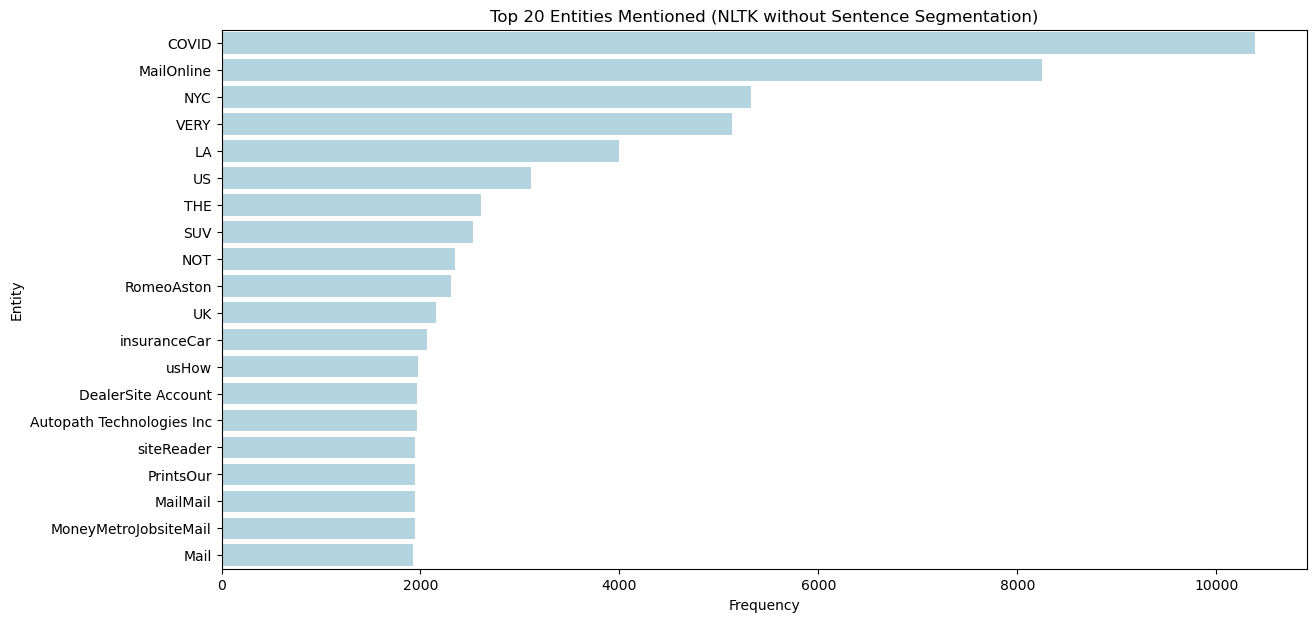

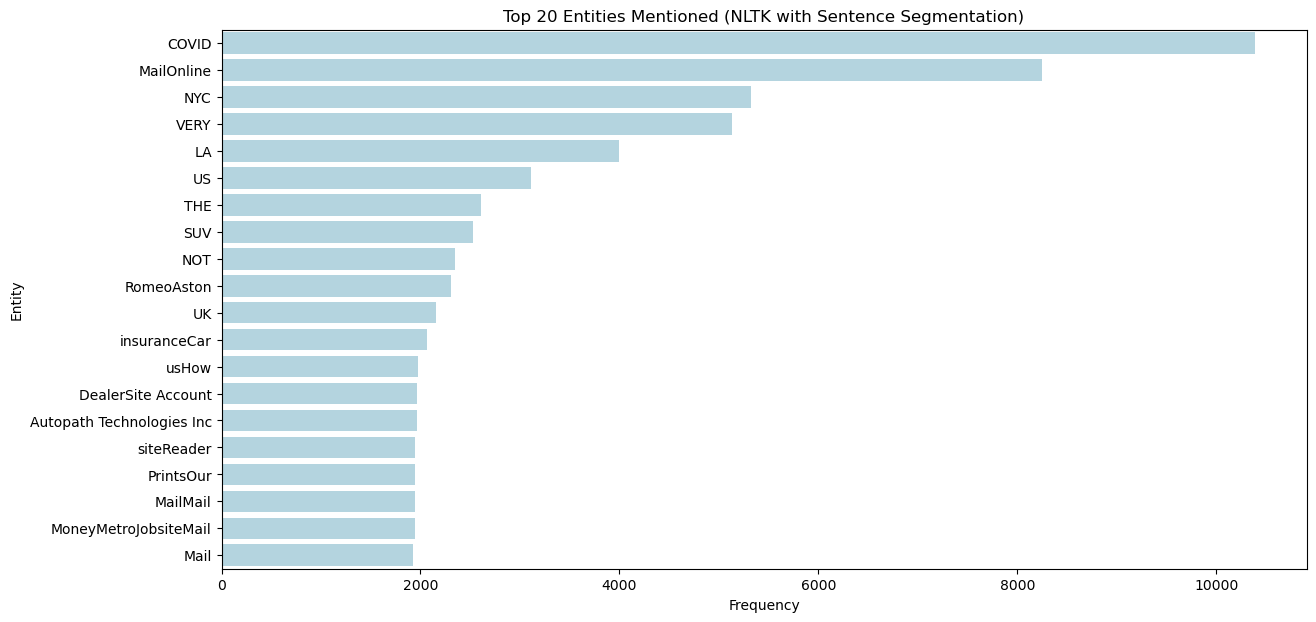

In [12]:
# Plot top 20 entities for NLTK (without sentence segmentation)
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Entity', data=nltk_top_20_df, color='lightblue')
plt.title('Top 20 Entities Mentioned (NLTK without Sentence Segmentation)')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

# Plot top 20 entities for NLTK (with sentence segmentation)
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Entity', data=nltk_sent_top_20_df, color='lightblue')
plt.title('Top 20 Entities Mentioned (NLTK with Sentence Segmentation)')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

#### Using SpaCy Approach

SpaCy approach performs the best when compared to NER approach above

In [13]:
# Initialize SpaCy models
nlp_spacy = spacy.load("en_core_web_sm")

# Function to extract named entities using SpaCy
def extract_entities_spacy(text):
    doc = nlp_spacy(text, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])
    return [(X.label_, X.text) for X in doc.ents]

# Define a function for Batch processing
def process_batch(df, field, batch_size=100):
    batches = [df[i:i + batch_size] for i in range(0, df.shape[0], batch_size)]
    results = []
    for batch in batches:
        with ThreadPoolExecutor() as executor:
            entities = list(executor.map(extract_entities_spacy, batch[field]))
        results.extend(entities)
    return results

# Extract entities for titles and texts separately using batch processing
news_df['title_entities'] = process_batch(news_df, 'clean_title')
news_df['text_entities'] = process_batch(news_df, 'clean_text')
tweets_df['text_entities'] = process_batch(tweets_df, 'clean_text')

In [14]:
# Function to get entities from specific field
def get_entities_from_field(df, field, entity_type):
    entities = Counter([item[1] for sublist in df[field] for item in sublist if item[0] == entity_type])
    return entities

# Get top companies in news titles, texts, and tweets
news_title_companies = get_entities_from_field(news_df, 'title_entities', 'ORG')
news_text_companies = get_entities_from_field(news_df, 'text_entities', 'ORG')
tweets_companies = get_entities_from_field(tweets_df, 'text_entities', 'ORG')

# Combine and find the most common company across news and tweets
all_top_companies = news_title_companies + news_text_companies + tweets_companies

# Get top locations in news titles, texts, and tweets
news_title_locations = get_entities_from_field(news_df, 'title_entities', 'GPE')
news_text_locations = get_entities_from_field(news_df, 'text_entities', 'GPE')
tweets_locations = get_entities_from_field(tweets_df, 'text_entities', 'GPE')

# Combine and find the most common locations across news and tweets
all_top_locations = news_title_locations + news_text_locations + tweets_locations

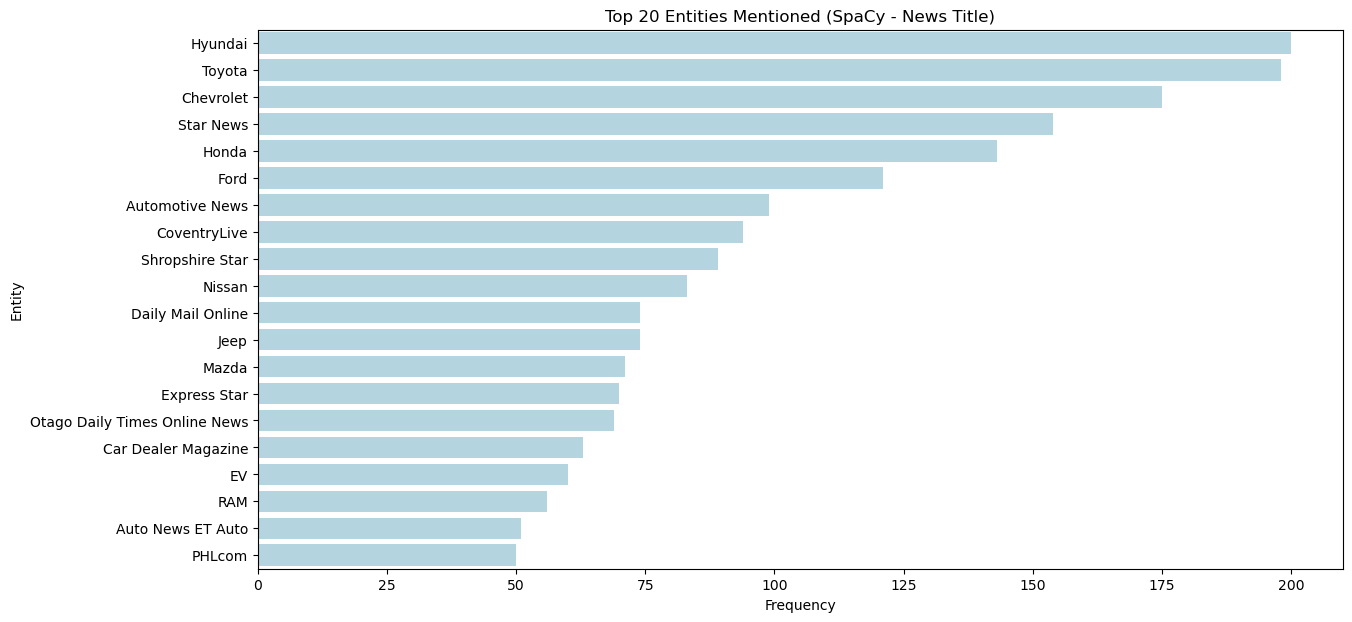

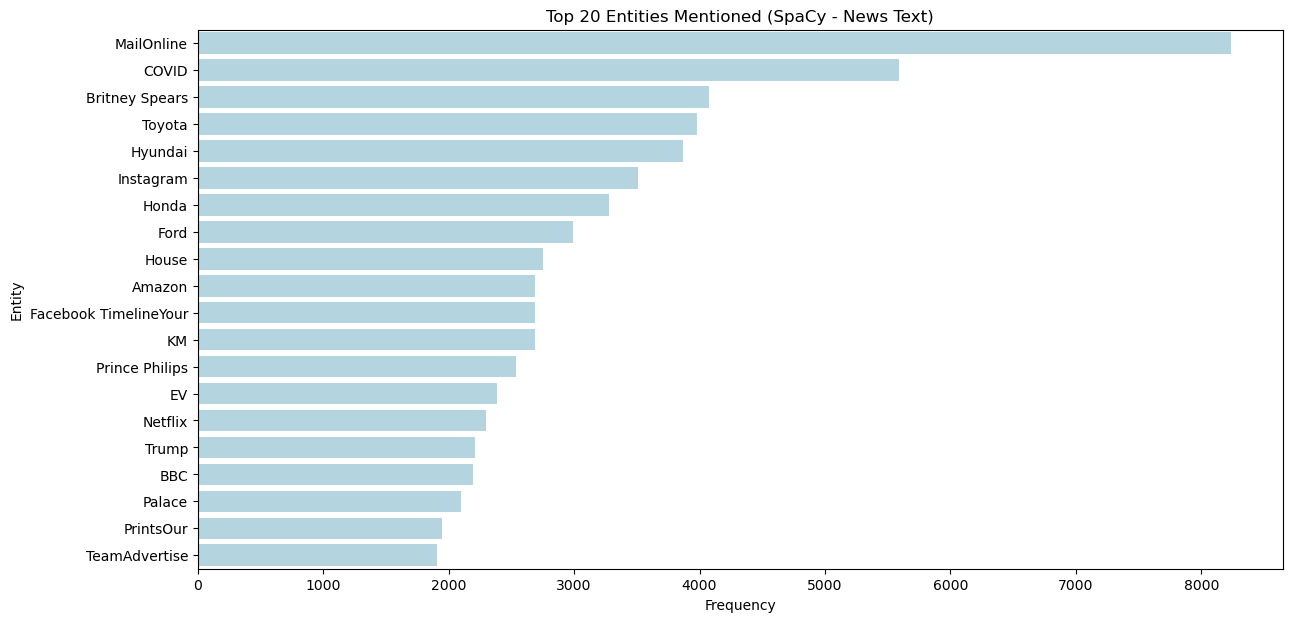

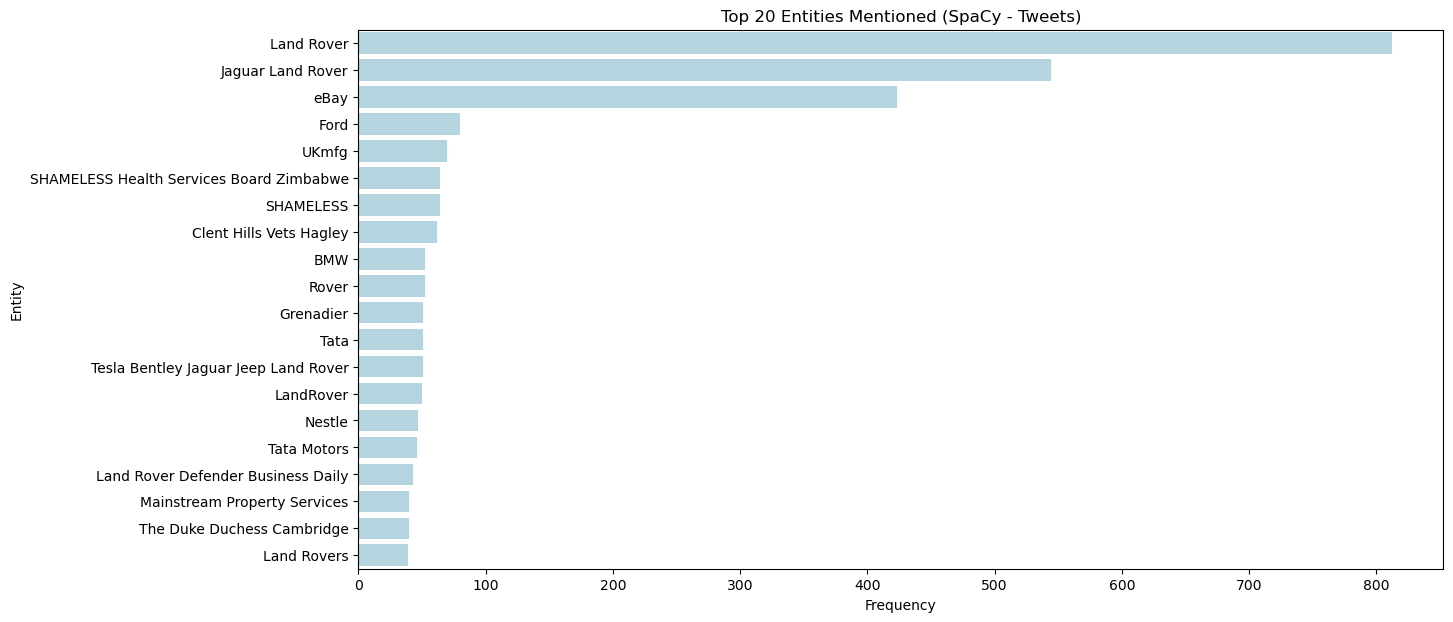

In [15]:
# Compare top 20 results for all news title, news text and tweets
spacy_entity_counts_news_title = Counter(news_title_companies)
spacy_top_20_entities_news_title = spacy_entity_counts_news_title.most_common(20)
spacy_entity_counts_news_text = Counter(news_text_companies)
spacy_top_20_entities_news_text = spacy_entity_counts_news_text.most_common(20)
spacy_entity_counts_tweets = Counter(tweets_companies)
spacy_top_20_entities_tweets = spacy_entity_counts_tweets.most_common(20)

# Display top 20 entities for all methods
spacy_top_20_news_title_df = pd.DataFrame(spacy_top_20_entities_news_title, columns=['Entity', 'Frequency'])
spacy_top_20_news_text_df = pd.DataFrame(spacy_top_20_entities_news_text, columns=['Entity', 'Frequency'])
spacy_top_20_tweets_df = pd.DataFrame(spacy_top_20_entities_tweets, columns=['Entity', 'Frequency'])

# Plot top 20 entities for SpaCy (News Title)
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Entity', data=spacy_top_20_news_title_df, color='lightblue')
plt.title('Top 20 Entities Mentioned (SpaCy - News Title)')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

# Plot top 20 entities for SpaCy (News Text)
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Entity', data=spacy_top_20_news_text_df, color='lightblue')
plt.title('Top 20 Entities Mentioned (SpaCy - News Text)')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

# Plot top 20 entities for SpaCy (Tweets)
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Entity', data=spacy_top_20_tweets_df, color='lightblue')
plt.title('Top 20 Entities Mentioned (SpaCy - Tweets)')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

### Conclusion on NER vs SpaCy:

We see that SpaCy gives us better result when looking companies and NER approach didn't do well as we see that most top entities are not companies (ORG). So we utilize SpaCy apporach which is better model to use here.

### Identify what is this company name, by looking at the entity distributions across both tweets and news articles
While analyzing news articles, extract separate entities from titles and texts

#### Within your Jupyter notebook: Show a table or chart with your top-20 companies (sorted in the descending order)
You are welcome to use separate tables for titles and texts of the news articles

In [16]:
# Let's identify top 20 companies (News Title)
top_20_companies_news_title = pd.DataFrame(news_title_companies.most_common(20), columns=['Company', 'Frequency'])
top_20_companies_news_title

,Company,Frequency
0,Hyundai,200
1,Toyota,198
2,Chevrolet,175
3,Star News,154
4,Honda,143
5,Ford,121
6,Automotive News,99
7,CoventryLive,94
8,Shropshire Star,89
9,Nissan,83


In [17]:
# Let's identify top 20 companies (News Text)
top_20_companies_news_text = pd.DataFrame(news_text_companies.most_common(20), columns=['Company', 'Frequency'])
top_20_companies_news_text

,Company,Frequency
0,MailOnline,8238
1,COVID,5592
2,Britney Spears,4077
3,Toyota,3980
4,Hyundai,3870
5,Instagram,3510
6,Honda,3276
7,Ford,2993
8,House,2755
9,Amazon,2691


In [18]:
# Let's identify top 20 companies (Tweets Text)
top_20_companies_tweets_text = pd.DataFrame(tweets_companies.most_common(20), columns=['Company', 'Frequency'])
top_20_companies_tweets_text

,Company,Frequency
0,Land Rover,812
1,Jaguar Land Rover,544
2,eBay,423
3,Ford,80
4,UKmfg,70
5,SHAMELESS Health Services Board Zimbabwe,64
6,SHAMELESS,64
7,Clent Hills Vets Hagley,62
8,BMW,52
9,Rover,52


### Conclusion on Primary Company:

MailOnline is a news outlet and the dataset is likely retrieved from MailOnline with lot of news articles referring, and that is why it is showing as the #1 entity. However, in my opinion we should weigh all News title, text and tweets equally and see the theme. We see that the top entities are mostly around car manufacturers and Ford is present in all 3 (News title, News text and Tweets at a high frequency) so we select <b>Ford</b> as our primary company. Case could be made for Toyota / Hyundai but they are not the top entity in Tweets.

In [19]:
combined_primary_company = "Ford"

### Identify what other companies are most frequently mentioned along with your primary company
What companies are most frequently mentioned within the same document (tweet and news article) as your primary company.

In [20]:
# Function to find companies mentioned with the primary company
def get_companies_mentioned_with_primary(df, primary_company, entity_field):
    co_mentioned_companies = Counter()
    for idx, row in df.iterrows():
        if primary_company in [entity[1] for entity in row[entity_field] if entity[0] == 'ORG']:
            co_mentioned_companies.update([entity[1] for entity in row[entity_field] if entity[0] == 'ORG' and entity[1] != primary_company])
    return co_mentioned_companies.most_common(20)

companies_with_primary_in_news = get_companies_mentioned_with_primary(news_df, combined_primary_company, 'text_entities')
companies_with_primary_in_tweets = get_companies_mentioned_with_primary(tweets_df, combined_primary_company, 'text_entities')

print("Companies frequently mentioned with the primary company in News:")
print(companies_with_primary_in_news)
print("")
print("Companies frequently mentioned with the primary company in Tweets:")
print(companies_with_primary_in_tweets)

Companies frequently mentioned with the primary company in News:
[('Toyota', 1126), ('Hyundai', 1117), ('Honda', 1013), ('EV', 778), ('MailOnline', 615), ('KM', 558), ('Chevrolet', 518), ('Jeep', 491), ('BMW', 448), ('Lexus', 438), ('COVID', 417), ('Nissan', 308), ('Automotive News', 307), ('Britney Spears', 290), ('YoursBuy From Home AvailableTap View Options', 281), ('Tesla', 258), ('GM', 246), ('Apple', 244), ('ShotsSpy', 230), ('Dodge', 230)]

Companies frequently mentioned with the primary company in Tweets:
[('Hyundai', 21), ('Jaguar Land Rover', 17), ('Tata Motors', 12), ('Toyota', 10), ('BMW Benz Lexus', 6), ('Ilorin BMW Benz Lexus', 6), ('android', 4), ('Cold Chilling AC', 4), ('Tata', 4), ('Land Rover', 4), ('Ibadan BMW Benz Lexus', 4), ('Honda', 3), ('Mercedes', 3), ('Wikipedia', 2), ('Lexus', 2), ('BMW Benz', 2), ('AUTOMATIC', 2), ('BP Shell', 2), ('Chrysler Fiat', 2), ('ford', 1)]


### Identify most frequent locations of events, by extracting appropriate named entities
Locations may include countries, states, cities, regions, etc.

In [21]:
# Let's identify top 20 locations (Combined)
top_20_locations_combined = pd.DataFrame(all_top_locations.most_common(20), columns=['Company', 'Frequency'])
top_20_locations_combined

,Company,Frequency
0,US,12154
1,UK,10323
2,LA,10137
3,Los Angeles,7948
4,London,6934
5,New York City,5385
6,Hollywood,4674
7,Miami,4032
8,California,3874
9,Beverly Hills,3811


In [22]:
# Let's identify top 20 locations (News Title)
top_20_locations_news_tile = pd.DataFrame(news_title_locations.most_common(20), columns=['Company', 'Frequency'])
top_20_locations_news_tile

,Company,Frequency
0,UK,159
1,US,133
2,India,71
3,North York,71
4,Taiwan,53
5,China,33
6,Russia,32
7,Australia,31
8,Ukraine,28
9,Richmond,20


In [23]:
# Let's identify top 20 locations (News Text)
top_20_locations_news_text = pd.DataFrame(news_text_locations.most_common(20), columns=['Company', 'Frequency'])
top_20_locations_news_text

,Company,Frequency
0,US,11985
1,LA,10128
2,UK,9886
3,Los Angeles,7944
4,London,6874
5,New York City,5382
6,Hollywood,4646
7,Miami,4027
8,California,3848
9,Beverly Hills,3811


In [24]:
# Let's identify top 20 locations (Tweets Text)
top_20_locations_tweets = pd.DataFrame(tweets_locations.most_common(20), columns=['Company', 'Frequency'])
top_20_locations_tweets

,Company,Frequency
0,Russia,466
1,UK,278
2,India,58
3,London,45
4,Meghan,43
5,Netherlands,36
6,US,36
7,China,32
8,Jamaica,29
9,South Africa,25


#### Additional: Vizulaize some SpaCy outputs

In [25]:
text = news_df['clean_text'].iloc[107]
sample_news_text = nlp_spacy(text)
sample_news_text

Mini appoints new director UK Ireland incumbent made boss BMW Group Canada Car Dealer Magazine Log inCar Dealer Magazine LogoThe logo Car Dealer Magazine Log inLatestUsed CarsLiveForumJobsPower Used Car Awards UCA KnowledgeSuppliers GuideLatest IssueTop Home News Mini appoints new director UK Ireland incumbent made boss BMW Group CanadaNewsMini appoints new director UK Ireland incumbent made boss BMW Group CanadaFederico Izzo appointed new director Mini UK IrelandItalian joins previous position managing director BMW Group Czech RepublicHe replaces David George made president CEO BMW Group CanadaNew man begin May Jack Williams seconds agoShareFederico Izzo appointed new director Mini UK Ireland Italian set take later yearIzzo succeeds David George role made president CEO BMW Group CanadaHe take UK Ireland May joins previous job managing director BMW Group Czech RepublicHe BMW Group since brings substantial experience gained across sales marketing international career automotive industry

In [26]:
from spacy import displacy

displacy.render(sample_news_text, jupyter = True, style = "ent")